In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
from generate import (
                        load_clip, 
                        save_mask_data, 
                        get_base_output_dict, 
                        encode_pillow_to_base64,
                        generate_prompts,
)
import os
import json
from PIL import Image
import torch
print(torch.cuda.is_available())
from spin import SPIN, InitialRequestError
import matplotlib.pyplot as plt
from typing import Optional
import pycocotools.mask as maskUtils
import nltk
from nltk.corpus import wordnet as wn
import tqdm
import numpy as np
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()
# Access environment variables
hf_api_key = os.getenv("HF_API_KEY")

# Ensure WordNet data is available
nltk.download('wordnet')

def get_annotations(coco, img_id):

    dict = {}

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    masks = []
    bboxes = []
    labels = []
    for ann in anns:
        mask = maskUtils.decode(ann['segmentation'])
        bbox = ann['bbox']
        label = ann['category_id']
        masks.append(mask)
        bboxes.append(bbox)
        labels.append(label)
    # print(f"Total masks: {len(masks)}")
    dict['masks'], dict['bboxes'], dict['label_ids'] = masks, bboxes, labels
    return dict

def get_subpart_by_part(parts, subparts):
    subparts = [[' '.join(label.split('-')[1:-1]), label.split('-')[-1]] for label in subparts['labels']]
    parts = [' '.join(label.split(' ')[1:]) for label in parts['labels']]
    class_hierarchy = {part: [] for part in parts}
    for subpart in subparts:
        for part in parts:
            if subpart[0] == part:
                class_hierarchy[part].append(subpart[-1])
    return class_hierarchy

# Function to refine caption
# instruction = """
# Review the following caption and add any missing ‘a,’ ‘an,’ or ‘s’ endings to make the caption grammatically correct, and improve its clarity to make it more understandable for text-to-image models if needed:
# """
# def refine_caption(caption, instruction=instruction):
#     prompt = f"{instruction} {caption}"
#     inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

#     # Generate a refined caption
#     output = model.generate(inputs.input_ids, max_new_tokens=200, temperature=0.7, num_beams=5, early_stopping=True)
#     refined_caption = tokenizer.decode(output[0], skip_special_tokens=True)
    
#     return refined_caption

def generate_caption(whole, class_hier, refine=False, hier_level=None):
    # Start with the object-level description
    caption = f"There is "
    if whole[0] in 'aeiou':
        caption += 'an '
    else:
        caption += 'a '
    caption += f"{whole} in the image composed of "
    if hier_level:
        parts = [whole + ' ' + key for key in class_hier.keys()]
    else:
        parts = [key for key in class_hier.keys()]
    if len(parts) > 1:
        part_dscp = ", ".join(parts[:-1]) + " and " + parts[-1] + '.'
    else:
        part_dscp = parts[0] + '.'
    caption += part_dscp
    
    # Add part-level annotations
    part_descriptions = []
    for part, subparts in class_hier.items():
        if subparts:
            if hier_level == 'object':
                subparts = [whole + ' ' + subpart for subpart in subparts]
            elif hier_level == 'full':
                subparts = [whole + ' ' + part + ' ' + subpart for subpart in subparts]
            # Start the part description
            part_text = f" The {part}"
            # Add subpart descriptions, if they exist
            if len(subparts) > 1:
                subpart_text = ", ".join(subparts[:-1]) + " and " + subparts[-1]
            else:
                subpart_text = subparts[0]

            part_text += f" has finer structures including {subpart_text}"
            
            # Append part description
            part_descriptions.append(part_text)
    
    # Join part descriptions into the final caption
    caption += ";".join(part_descriptions) + "."
    
    if refine:
        caption = refine_caption(caption)
    return caption


[nltk_data] Downloading package wordnet to /home/mozh7931/nltk_data...


True
True


[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mozh7931/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
print("Initialize CLIP model")
clip_text_model, clip_text_processor = load_clip()

Initialize BLIP and CLIP model


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

BLIP loaded  successfully!
CLIP loaded  successfully!


In [3]:
# generate prompts

annotation_dir = "../../PartImageNet/jsons"
image_dir = "../../PartImageNet/images"
split = "test"
spin_api = SPIN(
    annotation_dir=annotation_dir, image_dir=image_dir, split=split, download=True
)

# make dir
output_dir = "prompts"
os.makedirs(output_dir, exist_ok=True)

# load images for model inference
dataset_name = 'output_test'

## Get image IDs
# Get all image IDs in the dataset
img_ids = spin_api.getImgIds()
print(f"Total number of images in split {spin_api.split}: {len(img_ids)}")

# iterate over all images
for i, id in enumerate(img_ids):

    image_info = spin_api.subparts.loadImgs(id)[0]
    file_name = image_info["file_name"]

    image_path = f"{spin_api.image_dir}/{spin_api.split}/{file_name}.JPEG"
    
    # read image and convert to RGB image using PIL
    image_pil = Image.open(image_path).convert("RGB") # load image

    wholes, parts, subparts = get_annotations(spin_api.wholes, id), get_annotations(spin_api.parts, id), get_annotations(spin_api.subparts, id)
    
    subpart_categories = spin_api.get_categories(granularity="subpart")
    subparts['labels'] = [subpart_categories[label_id]['name'].lower() for label_id in subparts['label_ids']]
    
    part_categories = spin_api.get_categories(granularity="part")
    parts['labels'] = [part_categories[label_id]['name'].lower() for label_id in parts['label_ids']]
    parts['labels'] = [label.replace("tier", "tire") for label in parts['labels']]

    whole_categories = spin_api.get_categories(granularity="whole")
    wholes['labels'] = [whole_categories[label_id]['name'] for label_id in wholes['label_ids']]
    
    # print(subparts['labels'], parts['labels'], wholes['labels'])
    class_hier = get_subpart_by_part(parts, subparts)
    # print(class_hier)
    whole = spin_api.get_object_name_for_file(id)

    # extract exact name
    try:
        synset = wn.synset_from_pos_and_offset('n', int(file_name.split('_')[0][1:]))
        label = synset.name().split('.')[0].replace('_', ' ')
        # print(label)
    except Exception as e:
        print(f"Could not find label for {id}: {e}")
        label = whole
    file_name = label.replace(' ', '_') + '_box'

    # generate and save image caption
    caption = generate_caption(whole, class_hier)
    

    masks = subparts['masks'] + parts['masks'] + wholes['masks']
    bboxes = subparts['bboxes'] + parts['bboxes'] + wholes['bboxes']
    labels = subparts['labels'] + parts['labels'] + [whole]
    # masks =  [mask.tolist() if isinstance(mask, np.ndarray) else mask for mask in masks]
    # bboxes = [bbox.tolist() if isinstance(bbox, np.ndarray) else bbox for bbox in bboxes]

    # # save mask data
    generate_prompts(image_pil, masks, bboxes, labels, caption, output_dir, file_name, use_bbox=True, use_mask=False)
    if i == 10:
        break

File downloaded	successfully and saved to ../../PartImageNet/jsons/spin.zip
File unzipped successfully to ../../PartImageNet/jsons
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.44s)
creating index...
index created!
Total number of images in split test: 1040


In [1]:
!ls train-data/*.json > train.txt

In [44]:
# Initialize the model and tokenizer
# from transformers import AutoModelForCausalLM, AutoTokenizer
# model_name = "meta-llama/Llama-2-7b-chat-hf"  # replace with the model size you need
# tokenizer = AutoTokenizer.from_pretrained(model_name, token=hf_api_key)
# model = AutoModelForCausalLM.from_pretrained(model_name,token = hf_api_key, torch_dtype=torch.float16, device_map="auto")

import torch
from transformers import pipeline

model_id = "meta-llama/Llama-3.2-1B"

pipe = pipeline(
    "text-generation", 
    model=model_id, 
    torch_dtype=torch.float16, 
    token=hf_api_key,
    max_new_tokens=200, 
    device_map="auto"
)
instruction = """
Review the following caption and add any missing ‘a,’ ‘an,’ or ‘s’ endings to make the caption grammatically correct, and improve its clarity to make it more understandable for text-to-image models if needed, only output your answer:"""
def refine_caption(caption, instruction=instruction):
    prompt = f"{instruction} {caption}"
    output = pipe(caption)
    
    # Extract only the generated text from the pipeline output
    refined_caption = output[0]["generated_text"]
    return refined_caption


In [ ]:

from pycocotools.coco import COCO
import numpy as np
from PIL import Image
import skimage.io as io
import matplotlib.pyplot as plt
import tqdm
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

dataDir='../..'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)
annFile = '{}/annotations/captions_{}.json'.format(dataDir,dataType)
coco_caps=COCO(annFile)

print("Initialize CLIP model")
clip_text_model, clip_text_processor = load_clip()

# make dir
# output_dir = args.output_dir
output_dir = 'train-data/coco_train2017'
os.makedirs(output_dir, exist_ok=True)

# load images for model inference
dataset_name = 'COCO'

## Get image IDs
# Get all image IDs in the dataset
img_ids = coco.getImgIds()
print(f"Total number of images in COCO train: {len(img_ids)}")

for id in tqdm.tqdm(img_ids):
    img_meta_data = {} # store image meta data
    image_info = coco.loadImgs(id)[0]
    file_name = image_info["file_name"]

    image_path = f"{dataDir}/{dataType}/{file_name}"

    # read image and convert to RGB image using PIL
    image_pil = Image.open(image_path).convert("RGB") # load image

    # save raw image
    img_meta_data['image'] = encode_pillow_to_base64(image_pil.convert('RGB'))

    # save file name
    img_meta_data['file_name'] = image_path

    annIds = coco.getAnnIds(imgIds=id)
    anns = coco.loadAnns(annIds)
    if not anns:
        continue
    
    masks = []
    bboxes = []
    labels = []
    for ann in anns:
        mask = coco.annToMask(ann)
        masks.append(mask)
        bboxes.append(ann['bbox'])
        category_info = coco.loadCats(ann['category_id'])
        labels.append(category_info[0]['name'])

    # generate and save image caption
    annIds = coco_caps.getAnnIds(imgIds=id)
    caps = coco_caps.loadAnns(annIds)
    img_meta_data['caption'] = caps[0]['caption']

    # get base output dictionary
    output = get_base_output_dict(image_pil, dataset_name, file_name, data=img_meta_data)

    # save mask data
    save_mask_data(output_dir, masks, bboxes, labels, file_name, output, clip_text_model, clip_text_processor)


loading annotations into memory...
Done (t=12.56s)
creating index...
index created!
loading annotations into memory...
Done (t=0.76s)
creating index...
index created!
Initialize CLIP model


/projects/mozh7931/software/anaconda/envs/instdiff/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


CLIP loaded  successfully!
Total number of images in COCO train: 118287


  0%|          | 22/118287 [00:23<34:45:22,  1.06s/it]


KeyboardInterrupt: 

loading annotations into memory...
Done (t=12.40s)
creating index...
index created!
[]


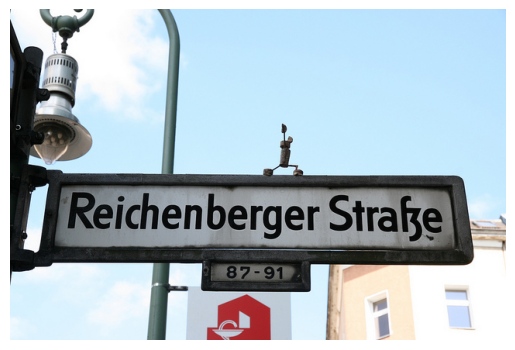

In [5]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

# Paths to COCO dataset
dataDir='../..'
dataType='train2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)

# Initialize COCO API
coco = COCO(annFile)

# Get image ID for the specific file
img_id = coco.getImgIds(imgIds=[345155])[0]
img = coco.loadImgs(img_id)[0]

plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'])
anns = coco.loadAnns(annIds)
print(anns)

